In [2]:
#Imports
import sys
import os
import numpy as np
from ast import literal_eval
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from collections import Counter

from sklearn.linear_model import LinearRegression

from model_inputs import split_on_h_group
import matplotlib.pyplot as plt
import seaborn as sns
import tables
import pdb

In [5]:
#FUNCTIONS
def count_aa(encoding):
    '''Count differnt amino acid occurence in encoding
    '''
    counts = Counter(encoding)

    aa_feature = []
    for i in range(0,22):
        if i in counts.keys():
            aa_feature.append(counts[i])
        else:
            aa_feature.append(0)

    return aa_feature


def create_features(df):
    '''Get features
    '''
    #Get MLAAdist
    evdist = np.asarray(df['MLAAdist_x'])

    #Get encodings
    enc1 = []
    enc2 = []
    [enc1.append(literal_eval(x)) for x in df['enc1']]
    [enc2.append(literal_eval(x)) for x in df['enc2']]
    #Get lengths
    l1 = np.asarray(df['l1'])
    l2 = np.asarray(df['l2'])
    aln_len = np.asarray(df['aln_len'])
    #Get starts and ends
    s1 = np.asarray(df['s1'])
    s2 = np.asarray(df['s2'])
    e1 = np.asarray(df['e1'])
    e2 = np.asarray(df['e2'])

    #Save features
    enc_feature = []


    for i in range(0, len(enc1)):
        enc_feature.append(count_aa(enc1[i])) #Append to list
        enc_feature[i].extend(count_aa(enc2[i])) #Extend 
        enc_feature[i].append(l1[i])
        enc_feature[i].append(l2[i])        
        enc_feature[i].append(aln_len[i])
        enc_feature[i].append(evdist[i])
        enc_feature[i].append(s1[i])
        enc_feature[i].append(s2[i])
        enc_feature[i].append(e1[i])
        enc_feature[i].append(e2[i])
     
   #Get RMSDs
    rmsds = df['RMSD_x']
    bins = np.arange(0,4.5,0.1)
    #bins = np.arange(0.5,2.5,0.05)
    #bins = np.insert(bins,0, 0)
    #bins = np.append(bins, 4.5)
    #Bin the TMscore RMSDs
    binned_rmsds = np.digitize(rmsds, bins)

    #Data
    X = np.asarray(enc_feature)
    y = np.asarray(rmsds)
    y_binned = np.asarray(binned_rmsds) 
    return(X, y, y_binned)

In [4]:
complete_df.columns

Index(['uid1', 'uid2', 'MLAAdist_x', 'RMSD_x', 'TMscore', 'H_group_x', 'C._x',
       'C.A._x', 'MLAAdist_y', 'RMSD_y', 'TMscore_high', 'TMscore_low',
       'H_group_y', 'C._y', 'C.A._y', 'aln_len', 'identity', 'lse1', 'lse2',
       'encoding', 'deviation', 'l1', 'l2', 's1', 's2', 'e1', 'e2',
       'binned_deviation', 'enc1', 'enc2'],
      dtype='object')

In [156]:
#Read df
complete_df = pd.read_csv('/home/pbryant/evolution/visual/complete_df.csv')
#Split
train_groups, valid_groups, test_groups = split_on_h_group(complete_df, 0.8)
train_df = complete_df[complete_df['H_group_x'].isin(train_groups)]
valid_df = complete_df[complete_df['H_group_x'].isin(valid_groups)]
test_df = complete_df[complete_df['H_group_x'].isin(test_groups)]

In [7]:
X_train,y_train, y_train_binned = create_features(train_df)
X_valid,y_valid, y_valid_binned = create_features(valid_df)

In [6]:
#Compare with linear regression
reg = LinearRegression().fit(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1), complete_df['RMSD_x'])
reg_predictions = reg.predict(np.asarray(complete_df['MLAAdist_x']).reshape(-1,1))
average_error = np.average(np.absolute(reg_predictions-complete_df['RMSD_x']))
print(average_error)

0.29990743494657146


In [12]:
#RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)


0.27216742202079447


In [8]:
#RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
clf.fit(X_train, y_train)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)

0.2562427414911579
0.2570243401759531


In [45]:
importances = clf.feature_importances_
#importances = -np.log(importances)

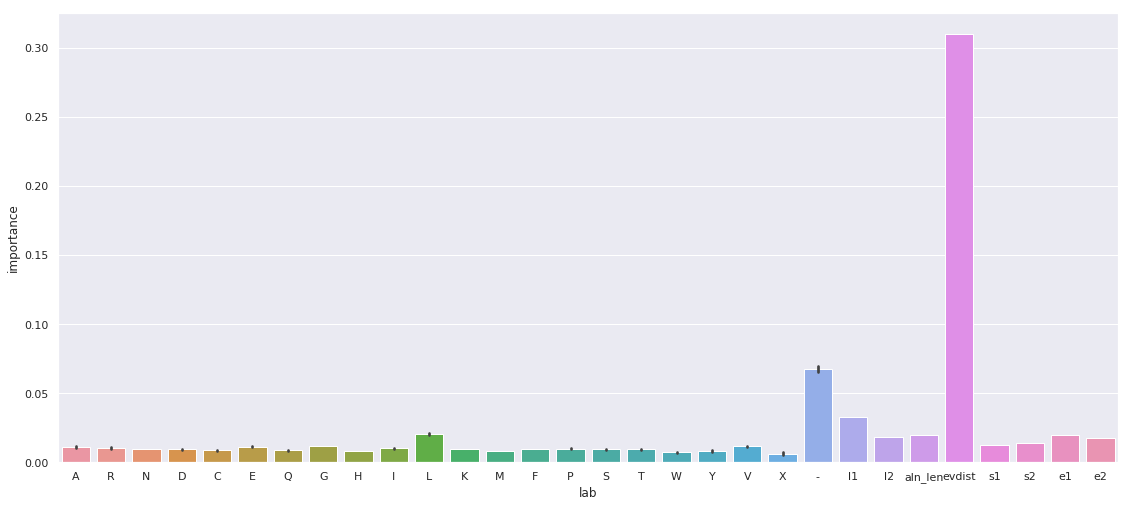

In [46]:
labels = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', '-', 'l1', 'l2', 'aln_len', 'evdist','s1', 's2', 'e1', 'e2']
imp_df = pd.DataFrame({'lab':labels, 'importance':importances})
sns.barplot(x='lab', y='importance', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

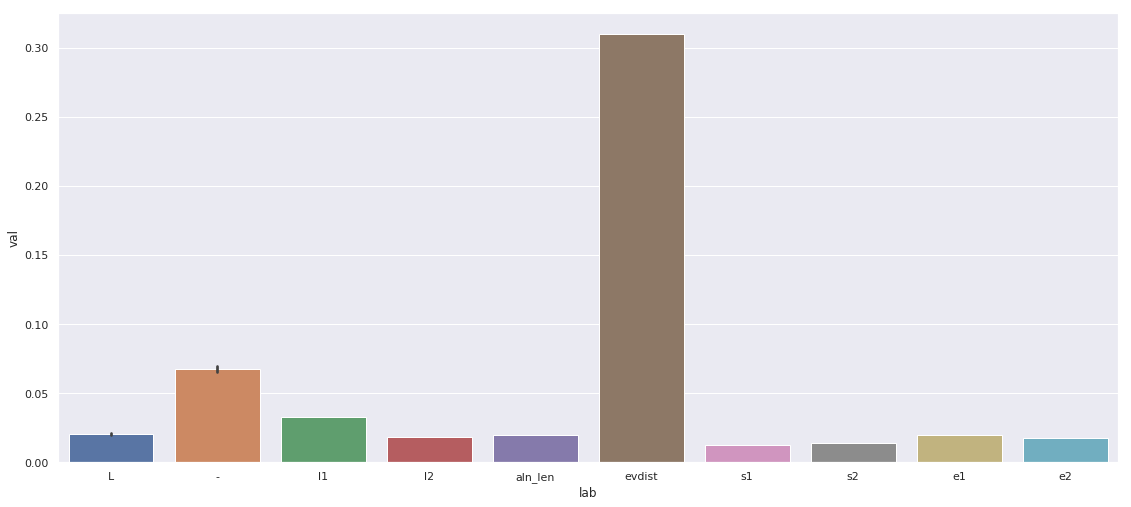

In [47]:
#It looks like Leucine, gaps, lengths of sequences and alignment as well as the evdist are the important features
importances_s = [importances[10],importances[21],importances[32],importances[43],importances[44],importances[45],importances[46],importances[47],importances[48],importances[49],importances[50],importances[51]]
labels = ['L', '-', 'L', '-', 'l1', 'l2', 'aln_len', 'evdist','s1', 's2', 'e1', 'e2']
imp_df = pd.DataFrame({'lab':labels, 'val':importances_s})
sns.barplot(x='lab', y='val', data = imp_df)
sns.set(rc={'figure.figsize':(19,8.27)})
plt.show()

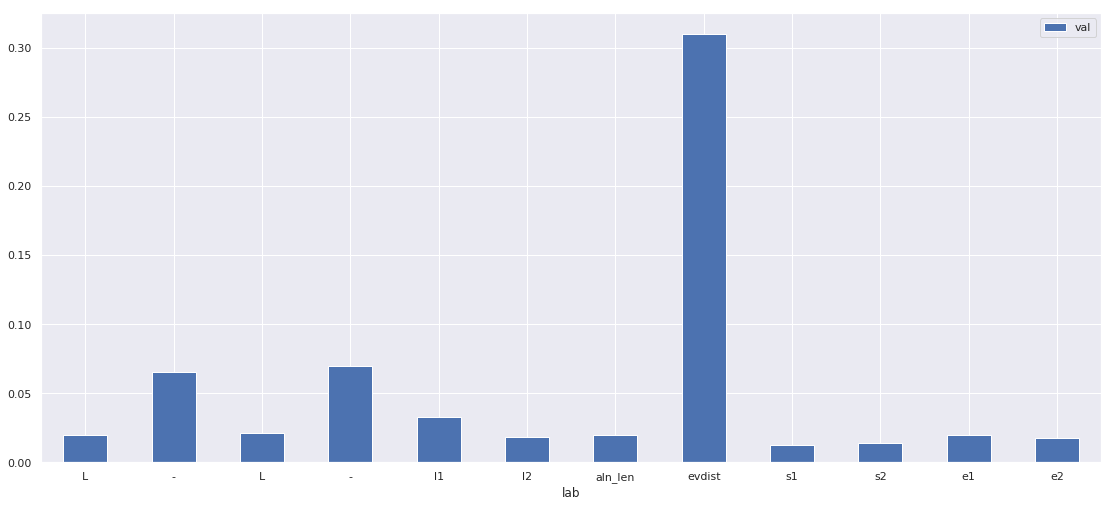

In [48]:
imp_df.plot.bar(x='lab', y='val',rot=0)

In [49]:
#Adaboost
clf = AdaBoostRegressor(random_state=0, n_estimators=7) #int asssignment of random state ensures same random intitator each run
# Fit on training data
clf.fit(X_train, y_train)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid))
print(average_error)

#Binned fitting
# Fit on training data
clf.fit(X_train, y_train_binned)

#predict
clf_predictions = clf.predict(X_valid)

#Average error
average_error = np.average(np.absolute(clf_predictions-y_valid_binned))
print(average_error*0.1)


0.2967062716497958
0.2943713238756529


In [3]:
#Using PROFILE representations of alignments
#Read df
complete_with_hmm_df = pd.read_csv('/home/pbryant/results/CATH/20190606/complete_with_hmm_df.csv')

In [4]:
complete_with_hmm_df.columns

Index(['Unnamed: 0', 'uid1', 'uid2', 'MLAAdist_x', 'RMSD_x', 'TMscore',
       'H_group_x', 'C._x', 'C.A._x', 'MLAAdist_y', 'RMSD_y', 'TMscore_high',
       'TMscore_low', 'H_group_y', 'C._y', 'C.A._y', 'aln_len', 'identity',
       'lse1', 'lse2', 'encoding', 'deviation', 'l1', 'l2', 's1', 's2', 'e1',
       'e2', 'binned_deviation', 'enc1', 'enc2', 'hmm_list1', 'hmm_list2',
       'transition_freq1', 'transition_freq2', 'local_div1', 'local_div2'],
      dtype='object')

In [72]:
def save_nparray(H_group_data, group, column):
    index = H_group_data.index
    for i in range(index[0], index[-1]+1):
        uid1 = H_group_data['uid1'][i]
        uid2 = H_group_data['uid2'][i]
        name = '/home/pbryant/results/CATH/20190606/'+group+'/'+uid1+'_'+uid2+'.'+column+'.txt'
        t1 = hmm_to_array(H_group_data[column][i])
        np.savetxt(name, t1, fmt='%d')


def hmm_to_array(tx):
    '''Convert hmm to array, replace * with 0
    '''
    tx = literal_eval(tx)
    for i in range(0,len(tx)):
        for j in range(0, len(tx[i])):
            if tx[i][j] == '*':
                tx[i][j] = 0
            else:
                tx[i][j] = int(tx[i][j])
            np.asarray(tx[i])
    return(np.asarray(tx))


In [48]:
groups = Counter(complete_with_hmm_df['H_group_x'])
groups = [*groups.keys()]
for group in groups:
    os.mkdir('/home/pbryant/results/CATH/20190606/'+group)
    H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    save_nparray(H_group_data, group)

In [51]:
#hmm2
for group in groups:
    H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    save_nparray(H_group_data, group, 'hmm_list2')

In [ ]:
#Transition frequencies and local divergences
columns = ['transition_freq1', 'transition_freq2', 'local_div1', 'local_div2']
for column in columns:
    for group in groups:
        H_group_data =  complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
        save_nparray(H_group_data, group, column)

In [62]:
#LOAD
hmm1 = {}
base = '/home/pbryant/results/CATH/20190606/'
for group in groups:
    H_group_data = complete_with_hmm_df[complete_with_hmm_df['H_group_x']==group]
    uid1 = [*H_group_data['uid1']]
    uid2 = [*H_group_data['uid2']]
    for i in range(0,len(uid1)):
        name = uid1[i]+'_'+uid2[i]
        c = np.loadtxt(base+group+'/'+name+'.hmm1.txt', dtype=int)
        hmm1[name] = c



In [68]:
len(hmm1['5ej3A00_2vg9A00'])

211

In [71]:
#Convert * to 0 and rest to ints
for i in range(0, len(hmm_list1)):
    item = hmm_list1[i]
    for j in range(0, len(item)):
        for k in range(0, len(item[j])):
            if item[j][k] == '*':
                item[j][k] = 0
            else:
                item[j][k] = int(item[j][k])
           
    hmm_list1[i] = np.asarray(item)
hmm_list1 = np.asarray(hmm_list1)

In [76]:
h5.close()
h5 = tables.open_file('file.h5', 'w', filters=tables.Filters(9, 'blosc:snappy'))

# Add some data
h5.create_carray(h5.root, 'name', obj=hmm_list1[0])

# Create a group (~folder) and put stuff inside
group = h5.create_group(h5.root,'H_group')
#h5.create_carray(group, 'other_name', obj=np.random.random((200,32)).astype(np.float32))

# A string:

#h5.create_carray(group, 'sequence', obj=np.array(list('PEPTIDE')))

# Adding metadata:
#h5.root._v_attrs['whatever'] = 'platypus'
#group._v_attrs['other_info'] = ':P'
h5.close()

h5 = tables.open_file('file.h5')
print(h5.root._v_attrs)
print(dir(h5.root._v_attrs))


/._v_attrs (AttributeSet), 5 attributes
['CLASS', 'FILTERS', 'PYTABLES_FORMAT_VERSION', 'TITLE', 'VERSION', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_f_copy', '_f_list', '_f_rename', '_g__delattr', '_g__setattr', '_g_close', '_g_copy', '_g_del_and_log', '_g_getattr', '_g_getnode', '_g_list_attr', '_g_log_add', '_g_new', '_g_remove', '_g_setattr', '_g_update_node_location', '_v__format_version', '_v__nodefile', '_v__nodepath', '_v_attrnames', '_v_attrnamessys', '_v_attrnamesuser', '_v_node', '_v_unimplemented']


In [3]:
#Split
train_groups, valid_groups, test_groups = split_on_h_group(complete_with_hmm_df, 0.8)